<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/09_AEPFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 81kB 4.1MB/s 


In [2]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [3]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [4]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [5]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [6]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filepath="/content/drive/MyDrive/colab-data/total434.pfs.se.norm.coxph.feather"

In [9]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [10]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [11]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [12]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [13]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=282, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=282, bias=True)
  )
  (survnet): Sequen

In [14]:
from torchsummary import summary
summary(model=netaesurv, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]         579,584
              ReLU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              ReLU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 64]           8,256
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

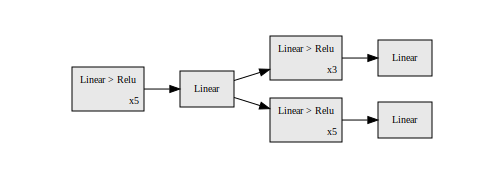

In [15]:
import hiddenlayer as hl
hl.build_graph(netaesurv, torch.zeros([1, in_features]))

In [16]:
# loss
loss = LossAELogHaz(0.6)

In [17]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [18]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [19]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

0:	[5s / 5s],		train_loss: 12.4639,	train_loss_surv: 1.2863,	train_loss_ae: 29.2303,	val_loss: 1.1441,	val_loss_surv: 1.3477,	val_loss_ae: 0.8387
1:	[5s / 10s],		train_loss: 1.2125,	train_loss_surv: 1.1629,	train_loss_ae: 1.2869,	val_loss: 1.1226,	val_loss_surv: 1.3124,	val_loss_ae: 0.8378
2:	[5s / 15s],		train_loss: 1.0919,	train_loss_surv: 1.1519,	train_loss_ae: 1.0017,	val_loss: 1.2046,	val_loss_surv: 1.4492,	val_loss_ae: 0.8378
3:	[5s / 21s],		train_loss: 1.1072,	train_loss_surv: 1.1767,	train_loss_ae: 1.0031,	val_loss: 1.2074,	val_loss_surv: 1.4539,	val_loss_ae: 0.8376
4:	[5s / 26s],		train_loss: 40.9155,	train_loss_surv: 1.1853,	train_loss_ae: 100.5108,	val_loss: 55.1620,	val_loss_surv: 1.4821,	val_loss_ae: 135.6817
5:	[5s / 31s],		train_loss: 4.7251,	train_loss_surv: 1.1486,	train_loss_ae: 10.0900,	val_loss: 1.2091,	val_loss_surv: 1.4498,	val_loss_ae: 0.8480
6:	[5s / 36s],		train_loss: 1.0866,	train_loss_surv: 1.1413,	train_loss_ae: 1.0047,	val_loss: 1.2226,	val_loss_surv: 1.479

In [20]:
res = model.log.to_pandas()

In [21]:
res.tail(20)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
80,1.078203,1.128501,1.002756,1.285246,1.583569,0.837761
81,1.075249,1.123805,1.002416,1.292763,1.596176,0.837644
82,1.074760,1.122981,1.002427,1.285184,1.583627,0.837519
83,1.080302,1.128633,1.007804,1.285543,1.584218,0.837530
84,1.074633,1.123070,1.001977,1.297943,1.604604,0.837951
85,1.076140,1.124582,1.003477,1.296386,1.602355,0.837434
86,1.074734,1.123078,1.002217,1.289913,1.591483,0.837559
87,1.076739,1.123007,1.007337,1.288655,1.589324,0.837653
88,1.075915,1.124084,1.003662,1.284290,1.582062,0.837631
89,1.073922,1.121605,1.002397,1.289741,1.590897,0.838008


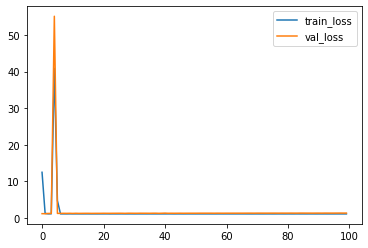

In [22]:
_ = res[['train_loss', 'val_loss']].plot()

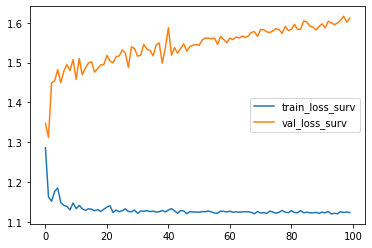

In [23]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

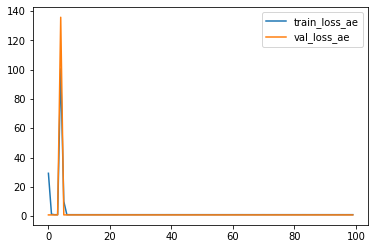

In [24]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [25]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [26]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.999962,0.999962,0.999962,0.999962,0.999962
1.455556,0.970704,0.970704,0.970704,0.970704,0.970704
2.911111,0.941445,0.941445,0.941445,0.941445,0.941445
4.366667,0.912187,0.912187,0.912187,0.912187,0.912187
5.822222,0.882928,0.882928,0.882928,0.882928,0.882928
...,...,...,...,...,...
125.177778,0.008685,0.008685,0.008685,0.008685,0.008685
126.633333,0.006526,0.006526,0.006526,0.006526,0.006526
128.088889,0.004367,0.004367,0.004367,0.004367,0.004367
129.544444,0.002208,0.002208,0.002208,0.002208,0.002208


In [27]:
surv2.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
0.000000,0.999962,0.999962,0.999962,0.999962,0.999962,0.999962,0.999962,0.999962,0.999962,0.999962
1.455556,0.970704,0.970704,0.970704,0.970704,0.970704,0.970704,0.970704,0.970704,0.970704,0.970704
2.911111,0.941445,0.941445,0.941445,0.941445,0.941445,0.941445,0.941445,0.941445,0.941445,0.941445
4.366667,0.912187,0.912187,0.912187,0.912187,0.912187,0.912187,0.912187,0.912187,0.912187,0.912187
5.822222,0.882928,0.882928,0.882928,0.882928,0.882928,0.882928,0.882928,0.882928,0.882928,0.882928
...,...,...,...,...,...,...,...,...,...,...
125.177778,0.008685,0.008685,0.008685,0.008685,0.008685,0.008685,0.008685,0.008685,0.008685,0.008685
126.633333,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526,0.006526
128.088889,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367,0.004367
129.544444,0.002208,0.002208,0.002208,0.002208,0.002208,0.002208,0.002208,0.002208,0.002208,0.002208


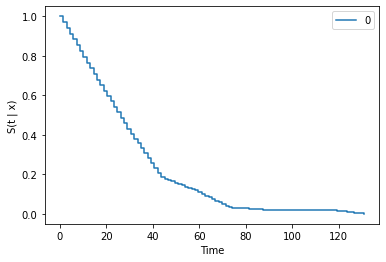

In [28]:
surv1.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

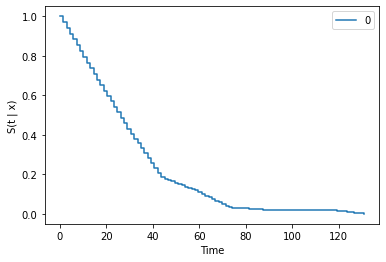

In [29]:
surv2.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [30]:
model.predict(x_test1[:2])

array([[-10.175867  ,  -0.8828138 ,  -0.44154158,   0.28778872,
         -0.5892128 ,   0.9418571 ,  -0.63351005,  -6.032008  ,
         -5.9761834 ,   6.0924816 ],
       [-10.175867  ,  -0.8828138 ,  -0.44154158,   0.28778872,
         -0.5892128 ,   0.9418571 ,  -0.63351005,  -6.032008  ,
         -5.9761834 ,   6.0924816 ]], dtype=float32)

In [31]:
model.predict_net(x_test1[:1])

(array([[-10.175867  ,  -0.8828138 ,  -0.44154158,   0.28778872,
          -0.5892128 ,   0.9418571 ,  -0.63351005,  -6.032008  ,
          -5.9761834 ,   6.0924816 ]], dtype=float32),
 array([[ 2.66951323e-02, -4.53658402e-03, -1.62105039e-02,
          1.33511275e-02, -3.80264148e-02,  1.88754722e-02,
          1.88810304e-02, -3.71809378e-02,  2.87455097e-02,
         -3.01441029e-02,  6.80613518e-03,  1.97692253e-02,
         -2.13478729e-02, -2.91912258e-03, -1.14150420e-02,
          4.21605781e-02, -2.16495479e-04, -2.57489085e-03,
          7.66225159e-03, -2.09792852e-02,  8.55784118e-03,
          3.64948213e-02, -3.34385782e-03, -4.13700938e-03,
          1.75807104e-02, -1.47229359e-02, -4.54403460e-04,
          1.29649863e-02,  3.33056003e-02,  4.39622030e-02,
         -1.85454413e-02, -7.88386166e-03,  1.45849586e-02,
         -3.04673687e-02, -2.08087116e-02,  4.80891764e-03,
         -2.39737332e-04,  4.15417179e-03, -3.32412571e-02,
          4.24045324e-03, -2.610316

In [32]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [33]:
evs1.concordance_td()

0.522680412371134

In [34]:
evs2.concordance_td()

0.5210651828298887

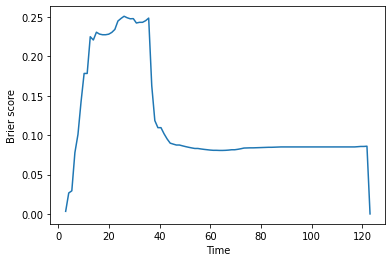

In [35]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

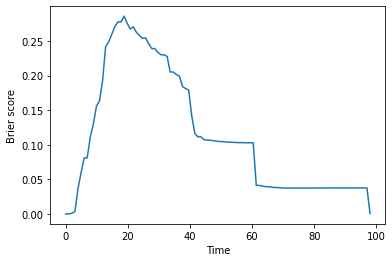

In [36]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

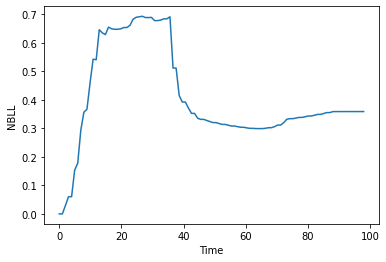

In [37]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

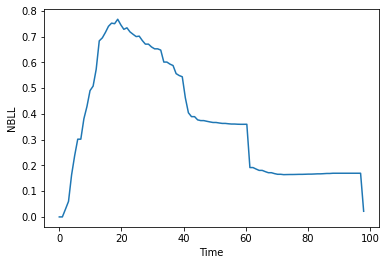

In [38]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [39]:
evs1.integrated_brier_score(time_grid)

0.12195008008024491

In [40]:
evs1.integrated_nbll(time_grid)

0.40703304937345736

In [41]:
evs2.integrated_brier_score(time_grid)

0.11490891377608493

In [42]:
evs2.integrated_nbll(time_grid)

0.3684613064291107